Simulation for branching process with random mutation. Each time the pathogen transmits to a new person, it mutates. In this version, only beta mutates while gamma remains constant. 

There are 2 functions, "sim" and "recurrent_sim".

"sim" represents a process without recurrent spillover. It seeds the population with an initial case (presumably spilled over from a reservoir). It branches until either the infection goes extinct, or it surpasses a threshold. In the latter case, we call it an outbreak. 

"recurrent_sim" represents a process with random recurrent spillover, at some rate alpha. It begins with a single founding spillover case. Then it branches until either the infection goes extinct, or surpasses a threshold. In the process with recurrent spillover, extinction is defined as any moment in time when there are 0 infected people. (Note this is not stable, as eventually a new spillover will occur).

Next steps: 
    1. Create graphs/visualizations.
    2. Allow gamma to mutate.
    4. Include backwards transmission.

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as sm

In [187]:
#parameters
gamma = 0.1 #recovery rate - constant for everyone right now
#initial case(s)
infecteds = [[0.09, 0]] #1st elt is beta, 2nd elt is time infected

#simulates infection WITHOUT recurrent spillover
#returns [0, t_ext] if extinction, where t is time of extinction. 
#returns [1] if outbreak
def sim(infecteds, gamma):
    
    max_infected = 100 #call it an outbreak if this many people are infected
    N_infected = len(infecteds) #number of infected people
    t_ext = np.inf
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        recovereds = [] #keep track of indices of recovered people
        
        for i, x in enumerate(infecteds): #i is index, x is value
            
            beta = x[0]
            t = x[1]

            #print("\n", "branching person", i)
            
            while True:
                
                dt = np.random.exponential(scale=1/(beta + gamma)) #interevent time (??)
                new_t = t + dt #time of new event
                
                #pick which new event, transmission or recovery, happens            
                ev = np.random.rand()
                prob_trans = beta / (beta+gamma) #probability of transmission instead of recovery

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    N_infected += 1
                    
                    #pick beta for new case
                    mut = np.random.normal(loc=0.0, scale=0.01, size=None) #mutation is a perturbation drawn from normal distribution
                    new_beta = max(0, beta + mut) #don't allow negative beta
                    
                    infecteds = np.append(infecteds, [[new_beta, new_t]], axis=0)
                    #print("new infection: ", [new_beta, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
                    
                    if N_infected == 0:
                        t_ext = new_t
                    
                    recovereds.append(i) #mark that they recovered
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #1. update the list of infecteds by deleting recovered people
        #2. and check if we have extinction/outbreak
        
        infecteds = np.delete(infecteds, recovereds, axis=0)
        
        if N_infected == 0:
            #print("\n", "extinction")
            return [0, t_ext]
        elif N_infected >= max_infected:
            #print("\n", "outbreak!")
            return [1]

In [204]:
#parameters
alpha = 0.1
max_t_ext = 0
t_s = 0

#simulates infection WITH recurrent spillover
#returns 1 if outbreak
#returns 0 if extinction

def recurrent_sim(alpha, max_t_ext, t_s): 
    
    #print("max_t_ext = ", max_t_ext)
    
    sim_output = sim(infecteds, gamma)

    #if simulation outbreaks, we are done
    if sim_output == [1]:
        
        #print("\n", "outbreak!")
        return 1
    
    else:
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1])
        
        #draw an interevent time to next spillover
        dt_s = np.random.exponential(scale=1/alpha)
        #print("drawing dt_s = ", dt_s)
        
        #actual time of next spillover
        t_s += dt_s
        #print("actual time of spillover is t_s = ", t_s)

        # if spillover occurs before max time of extinction, run another simulation
        if t_s < max_t_ext: 
            #print("a spillover occured! Running another simulation...")
            return recurrent_sim(alpha, max_t_ext, t_s)

        # if spillover occurs after extinction, end simulation and return 0
        else: 
            #print("next spillover too late. extinction!")
            return 0

In [189]:
#run a single simulation WITH recurrent spillover
recurrent_sim(alpha, max_t_ext, t_s)

0

In [212]:
#run many simulations WITH recurrent spillover
#returns the percentage of them that outbreak
def recurrent_sim_percentage(alpha):

    N_sims = 100
    N_outbreaks = 0

    for i in range(N_sims):
        if recurrent_sim(alpha, max_t_ext, t_s) == 1: N_outbreaks += 1

    print("percentage of outbreaks = ", N_outbreaks/N_sims)
    return N_outbreaks/N_sims

/Users/gracezhang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


percentage of outbreaks =  0.06
percentage of outbreaks =  0.22
percentage of outbreaks =  0.5
percentage of outbreaks =  0.69
percentage of outbreaks =  0.76
percentage of outbreaks =  0.84
percentage of outbreaks =  0.89
percentage of outbreaks =  0.91
percentage of outbreaks =  0.95
percentage of outbreaks =  0.94
percentage of outbreaks =  0.99
percentage of outbreaks =  0.96
percentage of outbreaks =  0.99
percentage of outbreaks =  0.99
percentage of outbreaks =  0.99
percentage of outbreaks =  0.96
percentage of outbreaks =  0.99
percentage of outbreaks =  0.98
percentage of outbreaks =  0.99
percentage of outbreaks =  0.97


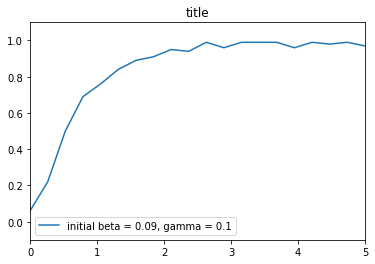

In [217]:
#plot alpha vs percentage of outbreaks (other parameters fixed)

max_alpha = 5

arr_alpha=np.linspace(0,5,20)
arr_percentage = np.zeros(len(arr_alpha))

for i in range(len(arr_alpha)):
    arr_percentage[i] = recurrent_sim_percentage(arr_alpha[i])

    
plt.plot(arr_alpha, arr_percentage, label='initial beta = 0.09, gamma = 0.1')

plt.title('title')
plt.ylim(-.1,1.1)
plt.xlim(0, max_alpha)
plt.legend()
#plt.grid(alpha=0.33)
plt.show()

In [198]:
#run many simulations WITHOUT recurrent spillover and see what percentage of them outbreak

N_sims = 1000
N_outbreaks = 0

for i in range(N_sims):
    if sim(infecteds, gamma) == [1]: N_outbreaks += 1
    
print("percentage of outbreaks = ", N_outbreaks/N_sims)

percentage of outbreaks =  0.04
